In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.lookup_tools import extractor
import numpy as np
from scipy.optimize import curve_fit
from hist import Hist
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
from coffea.analysis_tools import PackedSelection
from scipy.integrate import quad
import os

from coffea.ml_tools.torch_wrapper import torch_wrapper
from analyzer.core import analyzerModule
from analyzer.matching import object_matching
import pickle

import torch
import torch.nn as nn
import torch.jit as jit
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/lookup_tools/evaluator.py:7: FutureWarning: In version 2024.8.0 (target date: 2024-07-31 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.lookup_tools.json_lookup will be removed by August 2024. Please use lumi_tools or correctionlib instead!.
  from coffea.lookup_tools.json_lookup import json_lookup


## get and select events

In [2]:
fname = 'root://cmseos.fnal.gov//store/user/dmahon/condor/RPVSingleStopMC/NANOAOD-ALL/NANOAOD-1500_900.root'#"data/NANOAOD-1200_600.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    delayed=False
).events()

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced wi

In [2]:
def makeCutSet(x, s, *args):
    return [x[s > a] for a in args]

b_tag_wps = [0.0490, 0.2783, 0.7100]

def createObjects(events):
    good_jets = events.Jet[(events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.4)]
    fat_jets = events.FatJet[(events.FatJet.pt > 30) & (abs(events.FatJet.eta) < 2.4)]
    loose_top, med_top, tight_top = makeCutSet(
        fat_jets, fat_jets.particleNet_TvsQCD, 0.58, 0.80, 0.97
    )
    #loose_W, med_W, tight_W = makeCutSet(
    #    fat_jets, fat_jets.particleNet_WvsQCD, 0.7, 0.94, 0.98
    #)

    #deep_top_wp1, deep_top_wp2, deep_top_wp3, deep_top_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_TvsQCD, 0.436, 0.802, 0.922, 0.989
    #)
    #deep_W_wp1, deep_W_wp2, deep_W_wp3, deep_W_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_WvsQCD, 0.458, 0.762, 0.918, 0.961
    #)
    loose_b, med_b, tight_b = makeCutSet(
        good_jets, good_jets.btagDeepFlavB, *(b_tag_wps[x] for x in range(3))
    )

    el = events.Electron
    good_electrons = el[
        (el.cutBased == 4)
        & (el.miniPFRelIso_all < 0.1)
        & (el.pt > 30)
        & (abs(el.eta) < 2.4)
    ]
    mu = events.Muon
    good_muons = mu[
        (mu.mediumId) & (mu.miniPFRelIso_all < 0.2) & (mu.pt > 30) & (abs(mu.eta) < 2.4)
    ]
    events["good_jets"] = good_jets
    events["good_electrons"] = good_electrons
    events["good_muons"] = good_muons

    events["loose_bs"] = loose_b
    events["med_bs"] = med_b
    events["tight_bs"] = tight_b

    events["tight_tops"] = tight_top
    # events["med_tops"] = med_top
    # events["loose_tops"] = loose_top

    # events["tight_Ws"] = tight_W
    # events["med_Ws"] = med_W
    # events["loose_Ws"] = loose_W

    # events["deep_top_wp1"] = deep_top_wp1
    # events["deep_top_wp2"] = deep_top_wp2
    # events["deep_top_wp3"] = deep_top_wp3
    # events["deep_top_wp4"] = deep_top_wp4

    # events["deep_W_wp1"] = deep_W_wp1
    # events["deep_W_wp2"] = deep_W_wp2
    # events["deep_W_wp3"] = deep_W_wp3
    # events["deep_W_wp4"] = deep_W_wp4

    return events

def createSelection(events):
    """Baseline selection for the analysis.
Applies the following selection:
- Jets[0].pt > 300
- 4 <= nJets <= 6
- 0 leptons
- 2 medium bjets, at least one of which is tight
- delta_R(med_bjets[0],med_bjets[1]) > 1
    """

    selection = PackedSelection()
    good_jets = events.good_jets
    fat_jets = events.FatJet
    good_muons = events.good_muons
    good_electrons = events.good_electrons
    loose_b = events.loose_bs
    med_b = events.med_bs
    tight_b = events.tight_bs
    tight_top = events.tight_tops
    # selection = PackedSelection()
    filled_jets = ak.pad_none(good_jets, 4, axis=1)
    top_two_dr = ak.fill_none(filled_jets[:, 0].delta_r(filled_jets[:, 1]), False)

    filled_med = ak.pad_none(med_b, 2, axis=1)
    med_dr = ak.fill_none(filled_med[:, 0].delta_r(filled_med[:, 1]), False)
    # selection.add("trigger", (ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6))
    if "HLT" in events.fields:
        selection.add("hlt", (events.HLT.PFHT1050 | events.HLT.AK8PFJet360_TrimMass30))
    selection.add("highptjet", (ak.fill_none(filled_jets[:, 0].pt > 300, False)))
    selection.add("jets", ((ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6)))
    selection.add("0Lep", ((ak.num(good_electrons) == 0) & (ak.num(good_muons) == 0)))
    selection.add("2bjet", (ak.num(med_b) >= 2))
    selection.add("1tightbjet", (ak.num(tight_b) >= 1))
    # selection.add("jet_dr", ((top_two_dr < 4) & (top_two_dr > 2)).to_numpy())
    selection.add("b_dr", (med_dr > 1))
    return selection

In [4]:
events = createObjects(events)
mask = createSelection(events).all("highptjet", "jets", "0Lep", "2bjet", "1tightbjet", "b_dr")
events = events[mask]

## get QCD weights

In [3]:
import analyzer.datasets as ds
profile_repo = ds.ProfileRepo()
profile_repo.loadFromDirectory("profiles")
sample_manager = ds.SampleManager()
sample_manager.loadSamplesFromDirectory("datasets", profile_repo)

HT_CUTS = ['50to100', '100to200', '200to300', '300to500', '500to700', '700to1000', '1000to1500', '1500to2000', '2000toInf']

ht_weights = np.zeros(9)

In [4]:
for cut_idx in range(9):
    sample = sample_manager.getSet(f"QCDInclusive2018_HT{HT_CUTS[cut_idx]}")
    ht_weights[cut_idx] = sample.getWeight()

## neural net

In [3]:
class Net(jit.ScriptModule):
        def __init__(self):
            super(Net,self).__init__()
            self.fc1 = nn.Linear(14,7)
            self.fc2 = nn.Linear(7,1)
            #self.fc3 = nn.Linear(7,3)
        def forward(self,x):
            x = F.relu(self.fc1(x))
            #x = F.relu(self.fc2(x))
            #x = F.softmax(self.fc2(x),dim=1) # Muli-class
            x = F.sigmoid(self.fc2(x)) # Binary
            return x

In [44]:
#modelPath = '/uscms/home/dmahon/nobackup/NanoAODTools/CMSSW_10_6_19_patch2/src/PhysicsTools/NanoAODTools/python/postprocessing/singleStop/output/jetMatcherNNPyTorch/'
modelPath = '.'
modelTag = 'nominalBinaryCompressed0p67_24-09-18-20-06' #'nominalBinaryUncompressed0p67_24-09-18-19-53'

model = torch.load("{}/{}/jetMatcherNNTraced.pt".format(modelPath,modelTag))

scl = open('{}/{}/scaler.pkl'.format(modelPath,modelTag), 'rb')
scaler = pickle.load(scl)

/usr/local/lib/python3.10/site-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
from analyzer.modules.mass_reconstruction import jetAssignmentNN

In [80]:
model_uncomp0p67 = jetAssignmentNN("nominalBinaryUncompressed0p67_24-09-18-19-53/jetMatcherNNTraced.pt")
outputs_uncomp0p67 = model_uncomp0p67(events)

(<Array [-1.35, 0.848, 0.157, -1.51, ..., 0.15, 1.12, 1.24] type='14 * float64'>,)


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/ml_tools/helper.py:176: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


In [7]:
jets = events.good_jets
ak.unflatten(outputs_uncomp0p67,ak.num(jets))

NameError: name 'outputs_uncomp0p67' is not defined

In [45]:
def m3_m4_m3NN(ev):
    ev = createObjects(ev)
    mask = createSelection(ev).all("highptjet", "jets", "0Lep", "2bjet", "1tightbjet","b_dr")
    ev = ev[mask]

    jets = ev.good_jets
    if len(jets) == 0: return 0, 0, 0, 0
    flat_jets = ak.flatten(jets)

    m3 = jets[:,0:3].sum() # Change for compressed [,0:3] vs. uncompressed [,1:4]
    m4 = jets[:,0:4].sum()

    m134 = jets[:,[0,2,3]].sum()
    m56  = jets[:,4:6].sum()
    mAll = jets.sum()

    ones = ak.ones_like(jets.pt)

    imap = {
        "features": {
            "iJet":         ak.flatten(ak.local_index(jets, axis=1)),
            "jetPT": 		flat_jets.pt,
            "jetEta": 		flat_jets.eta,
            "jetPhi": 		flat_jets.phi,
            "jetBScore": 	flat_jets.btagDeepFlavB,
            "m3M": 			ak.flatten(ones * m3.mass),
            "m3PT": 		ak.flatten(ones * m3.pt),
            "m3Eta": 		ak.flatten(ones * m3.eta),
            "m3Phi": 		ak.flatten(ones * m3.phi),
            "m4M": 			ak.flatten(ones * m4.mass),
            "m4PT":			ak.flatten(ones * m4.pt),
            "m4Eta":		ak.flatten(ones * m4.eta),
            "m4Phi":	    ak.flatten(ones * m4.phi),
            
            # "m134M": 			ak.flatten(ones * m134.mass),
            # "m134PT":			ak.flatten(ones * m134.pt),
            # "m134Eta":		ak.flatten(ones * m134.eta),
            # "m134Phi":	    ak.flatten(ones * m134.phi),
            # "m56M": 			ak.flatten(ones * m56.mass),
            # "m56PT":			ak.flatten(ones * m56.pt),
            # "m56Eta":		ak.flatten(ones * m56.eta),
            # "m56Phi":	    ak.flatten(ones * m56.phi),
            # "mAllM": 			ak.flatten(ones * mAll.mass),
            # "mAllPT":			ak.flatten(ones * mAll.pt),
            # "mAllEta":		ak.flatten(ones * mAll.eta),
            # "mAllPhi":	    ak.flatten(ones * mAll.phi),
            
            "nJets":        ak.flatten(ones * ak.num(jets)),
        }
    }

    net_input = ak.concatenate([x[:, np.newaxis] for x in imap['features'].values()], axis=1)
    net_input = (net_input - scaler.mean_) / scaler.scale_
    net_input = ak.to_numpy(net_input)
    net_input = torch.Tensor(net_input)
    #net_input = scaler.transform(net_input)
    
    outputs = model(torch.Tensor(net_input)).detach().numpy()

    #top_3_idx = ak.argsort(ak.unflatten(outputs[:,1], ak.num(jets)), axis=1)[:, -3:] # Multi-class
    #top_3_idx = ak.flatten(ak.argsort(ak.unflatten(outputs, ak.num(jets)), axis=1)[:,-3:],axis=2) # Binary
    top_3_idx = ak.flatten(ak.argsort(ak.unflatten(outputs, ak.num(jets)),axis=1)[:,-3:],axis=2) # Binary

    ### Default m4 ###
    #m4_NN = m4
    
    ### Highest remaining pT ###
    top_3_excl_mask = (ak.local_index(jets,axis=1) != top_3_idx[:,0]) & (ak.local_index(jets,axis=1) != top_3_idx[:,1]) & (ak.local_index(jets,axis=1) != top_3_idx[:,2])
    stop_b = jets[top_3_excl_mask][:,0] # Highest remaining pT
    m4_NN = jets[top_3_idx].sum() + stop_b
    
    ### Highest remaining b score ###
    #highest_b_idx = ak.argsort(jets[top_3_excl_mask].btagDeepFlavB,axis=1)[:,-1]
    #highest_b_mask = (ak.local_index(jets,axis=1)) == highest_b_idx
    #stop_b = jets[highest_b_mask][:,0] # Highest remaining b score
    #m4_NN = m3_top_3_nn_charg_score + stop_b
    
    ### stop = sum of highest 4 chargino scores ###
    #m4_NN = jets[ak.flatten(ak.argsort(ak.unflatten(outputs, ak.num(jets)),axis=1)[:,-4:],axis=2)].sum()

    ### stop = sum of highest 3 chargino scores + lowest chargino score###
    #m4_NN = jets[top_3_idx].sum()
    #m4_NN = m4_NN + jets[ak.argsort(ak.unflatten(outputs, ak.num(jets)),axis=1)[:,0]].sum()    
    
    top_3_charg_score_sum = jets[top_3_idx].sum()
    m3_top_3_nn_charg_score = top_3_charg_score_sum

    return m3, m4, m3_top_3_nn_charg_score, m4_NN

In [6]:
def getEvents(mass_point):
    filename = 'root://cmseos.fnal.gov//store/user/dmahon/condor/RPVSingleStopMC/NANOAOD-ALL/NANOAOD-{}.root'.format(mass_point)
    ev = NanoEventsFactory.from_root(
        {filename: "Events"},
        schemaclass=NanoAODSchema,
        metadata={"dataset": "DYJets"},
        delayed=False
    ).events()
    return ev

## histograms

In [42]:
def hist_comparison(mass_point,plotDir):
    
    ev = getEvents(mass_point)
    
    true_mstop, true_mchi = mass_point.split("_")

    m3, m4, m3_NN, m4_NN = m3_m4_m3NN(ev)

    #hist_naive = Hist.new.Regular(40, 0, 2000, name="naive method 1200_600").Double().fill(
    #m3.mass)
    #hist_NN = Hist.new.Regular(40, 0, 2000, name="NN chargino mass reconstruction 1200_600").Double().fill(
    #m3_NN.mass)
    hist_naive = Hist.new.Regular(60, 0, 3000, name="naive method 1200_600").Double().fill(
    m4.mass)
    hist_NN = Hist.new.Regular(60, 0, 3000, name="NN chargino mass reconstruction 1200_600").Double().fill(
    m4_NN.mass)
    
    hist_naive.plot(linewidth=2, label="Simple reco")
    hist_NN.plot(linewidth=2, label="Reco with NN")

    #plt.title(f"Chargino mass reconstruction alg comparison\n m_stop = {true_mstop} GeV, m_chi = {true_mchi} GeV")
    plt.title('$m_\\tilde{{t}} = {}$ GeV, $m_\\tilde{{\\chi}} = {}$ GeV'.format(true_mstop,true_mchi))
    #plt.xlabel('$m_{\\tilde{\\chi}}$ [GeV]')
    plt.xlabel('$m_{\\tilde{t}}$ [GeV]')
    plt.ylabel('$N_\\text{events}$')

    #plt.gca().axvline(int(true_mchi),ymin=0,ymax=1,color='r',linestyle='--',label='True $m_{\\tilde{\\chi}}$')
    plt.gca().axvline(int(true_mstop),ymin=0,ymax=1,color='r',linestyle='--',label='True $m_{\\tilde{t}}$')
    #plt.gca().axvline(int(true_mstop),ymin=0,ymax=1,color='r',linestyle='--')

    plt.legend()
    #plt.savefig('{}/m3_{}.pdf'.format(plotDir,mass_point))
    plt.show()

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


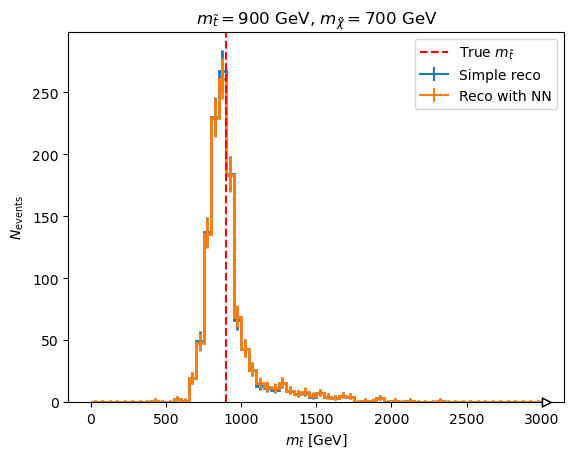

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


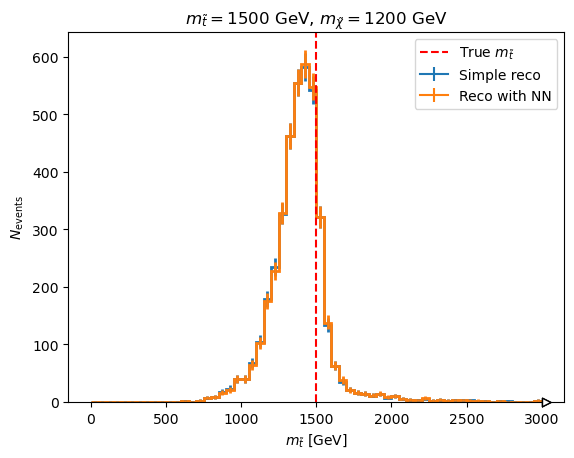

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


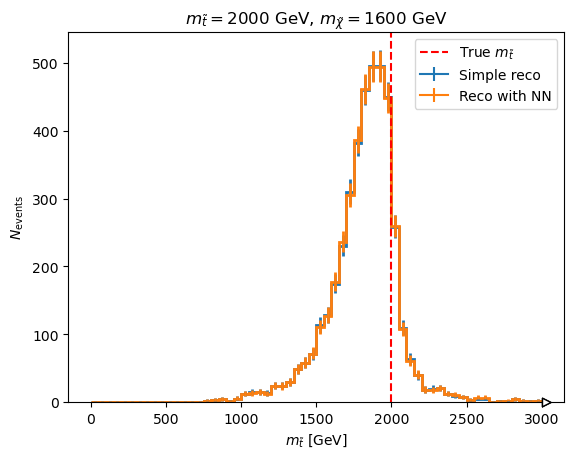

In [46]:
for masspoint in ['900_700','1500_1200','2000_1600']:#['1000_600','1500_600','2000_900']:#["1200_400","1200_600","1200_900","1500_400","1500_900", "1500_1100", "2000_400", "2000_900", "2000_1500"]:
    plotDir = 'plots/{}'.format(modelTag)
    if not os.path.exists(plotDir): os.makedirs(plotDir)
    hist_comparison(masspoint,plotDir)

## Plot 2D Distributions: Signal

In [14]:
masspoint = '1200_1100' #masspoint
m3, m4, m3_top_3_nn_charg_score, m4_NN = m3_m4_m3NN(getEvents(masspoint))
m3_top_3_nn_charg_score = m3_top_3_nn_charg_score.mass
HSig, xedges, yedges = np.histogram2d(m3.mass.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 51), np.linspace(0, 3000, 51)))
HSig2, xedges2, yedges2 = np.histogram2d(m3_top_3_nn_charg_score.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 51), np.linspace(0, 3000, 51)))

/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


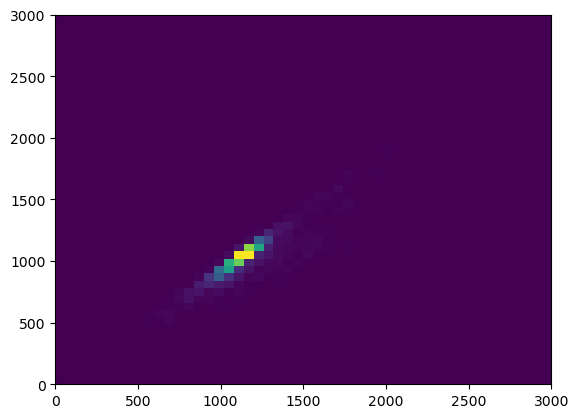

In [15]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, HSig)

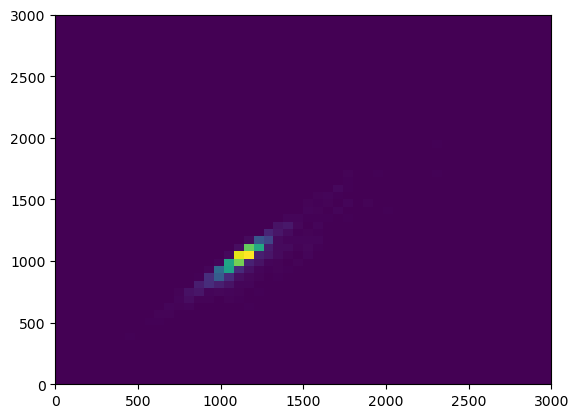

In [16]:
fig, ax = plt.subplots()
X2, Y2 = np.meshgrid(xedges2, yedges2)
ax.pcolormesh(X, Y, HSig2)

## Plot 2D Distributions: Background

50to100


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

100to200
200to300
300to500
500to700


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

700to1000


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

1000to1500


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

1500to2000


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

2000toInf


/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:254: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/srv/.application_data/virtual_envs/coffeaenv/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:247: RuntimeWa

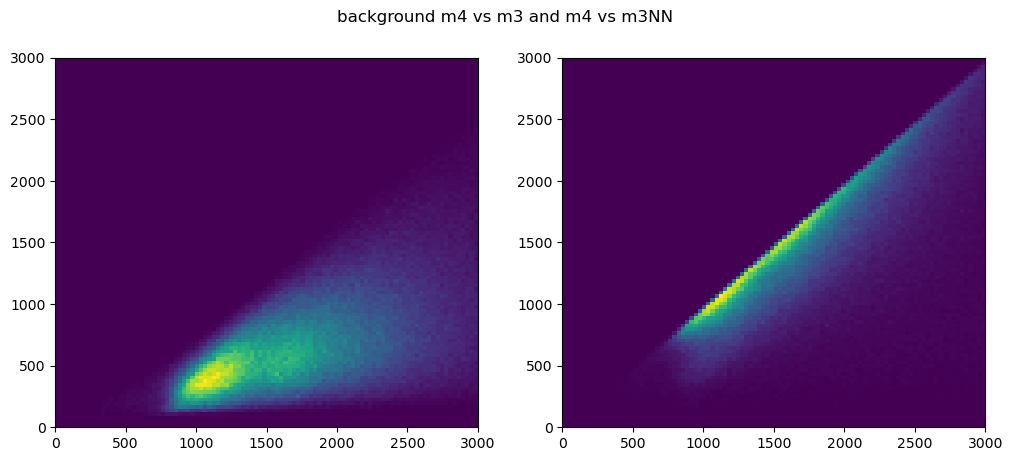

In [24]:
H, xedges, yedges = np.histogram2d([],[],bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))
H2, xedges2, yedges2 = np.histogram2d([],[],bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))
for ht in ['50to100', '100to200', '200to300', '300to500', '500to700', '700to1000', '1000to1500', '1500to2000', '2000toInf']:
    print(ht)
    filename = 'root://cmseos.fnal.gov//store/user/ckapsiak/SingleStop/Skims/Skims_2023_09_05/RunIISummer20UL18NanoAODv9_QCD_HT{}.root'.format(ht)
    qcdevents = NanoEventsFactory.from_root(
        {filename: 'Events'},
        schemaclass=NanoAODSchema,
        metadata={"dataset": "DYJets"},
        delayed=False
    ).events()

    m3, m4, m3NN = m3_m4_m3NN(qcdevents)
    
    if isinstance(m3, int): continue
    else:
        m3NN = m3NN.mass
        H += np.histogram2d(m3.mass.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))[0]
        H2 += np.histogram2d(m3NN.to_numpy(), m4.mass.to_numpy(), bins=(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101)))[0]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
X, Y = np.meshgrid(xedges, yedges)
ax[0].pcolormesh(X, Y, H)
ax[1].pcolormesh(X, Y, H2)
plt.suptitle(f"background m4 vs m3 and m4 vs m3NN")
plt.savefig('{}/QCD.pdf'.format(plotDir))
plt.show()

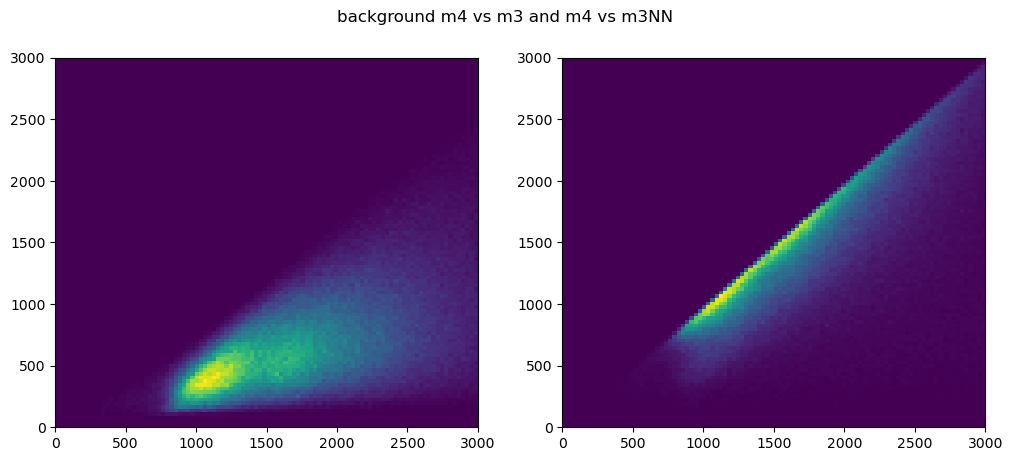

In [34]:
xedges = np.linspace(0, 3000, 101)
yedges = np.linspace(0, 3000, 101)
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
X, Y = np.meshgrid(xedges, yedges)
ax[0].pcolormesh(X, Y, H)
ax[1].pcolormesh(X, Y, H2)
plt.suptitle(f"background m4 vs m3 and m4 vs m3NN")
plt.savefig('{}/QCD.pdf'.format(plotDir))

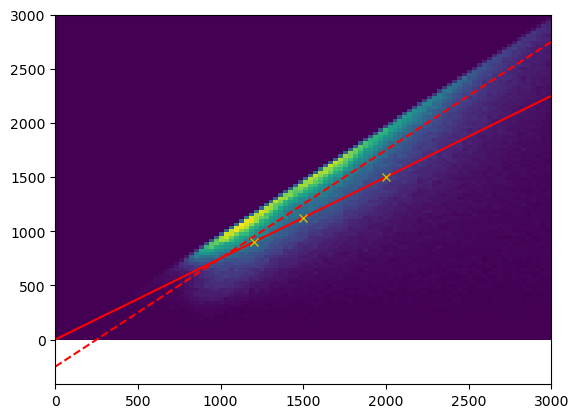

In [28]:
X, Y = np.meshgrid(np.linspace(0, 3000, 101), np.linspace(0, 3000, 101))
plt.pcolormesh(X,Y,H2)
plt.plot(np.linspace(0,3000,101),0.75*np.linspace(0,3000,101),'r-')
plt.plot(np.linspace(0,3000,101),np.linspace(0,3000,101)-250,'r--')
plt.plot([1200,1500,2000],[900,1125,1500],'yx')
plt.show()